This script is used to produce Figure S5 (trends and change in mean bloom start, end, and length between 1970 and 2100) for the Payne et al. paper "End-of-century Arctic Ocean phytoplankton blooms start a month earlier due to anthropogenic climate change". 

1. Import Packages

In [3]:
import numpy as np
import numpy.ma as ma
import xarray as xr
import glob
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import math
import matplotlib.path as mpath
import xesmf as xe
import matplotlib.ticker as mticker

2. Read in a randomly chosen NPP file. This is used to generate latitude (lat) and longitude (lon) fields for CESM files.

In [4]:
# Select a file
vdir = 'ocn'
vnam = 'photoC_diat_zint_2'
fdir = '/glade/campaign/cgd/cesm/CESM2-LE/'+ vdir + '/proc/tseries/day_1/' + vnam + '/'
fnam = 'b.e21.BSSP370cmip6.f09_g17.LE2-1301.003.pop.h.ecosys.nday1.photoC_diat_zint_2.20450102-20550101.nc'

ncfile = xr.open_dataset(fdir + fnam)
lon = ncfile.TLONG.values
lat = ncfile.TLAT.values

# Interpolate lat and lon values over holes in the arrays
ok = ~np.isnan(lon)
xp = ok.ravel().nonzero()[0]
fp = lon[~np.isnan(lon)]
x  = np.isnan(lon).ravel().nonzero()[0]
lon[np.isnan(lon)] = np.interp(x, xp, fp)

ok = ~np.isnan(lat)
xp = ok.ravel().nonzero()[0]
fp = lat[~np.isnan(lat)]
x  = np.isnan(lat).ravel().nonzero()[0]
lat[np.isnan(lat)] = np.interp(x, xp, fp)


3. Read in bloom start (max_25) and end (max_25_2) files. These files were created for each year and across all ensemble members using the "BloomMetrics" script. Bloom start occurs on the date when biomass first surpasses 25% of the maximum biomass at any given grid cell, and end occurs on the date when biomass first diminishes below 25% of the maximum following the peak in biomass. Afterwards, I set all bloom start and end values to 'nan' if they are equal to zero.

In [5]:
max_25 = np.zeros([14,384,320,50]); max_25_2 = np.zeros([14,384,320,50]); 
for yrset in np.arange(0,14):
    yrnum = str(1970 + yrset*10)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25.txt")
    max_25[yrset,:,:,:] = dir.reshape(384,320,50)
    dir = np.loadtxt("/glade/u/home/cpayne/Projects/BloomLength/AnnualGC/" + yrnum + "_max_25_2.txt")
    max_25_2[yrset,:,:,:] = dir.reshape(384,320,50)

max_25 = np.where(max_25==0, np.nan, max_25)
max_25_2 = np.where(max_25_2==0, np.nan, max_25_2)

In [6]:
acdir = '/glade/collections/cmip/CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Ofx/areacello/gn/files/d20190308/areacello_Ofx_CESM2_historical_r1i1p1f1_gn.nc'
acfil = xr.open_dataset(acdir)
areacello = acfil['areacello'].values # tarea <- ocean files


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'areacello' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


5. Choose the later decade to use in the analysis (which starts in 1970). I then calculate mean slope of the trend (using linear regression). If the mean slope is not significant (see Text A1 of the paper), it is not plotted.

In [51]:
yr2 = 13
yy = 1970 + 10 * yr2
vari = max_25_2[0:yr2+1,:,:,:]-max_25[0:yr2+1,:,:,:]

In [52]:
valslp = np.full([384,320], np.nan); 
mnslp = np.full([384,320],np.nan);
import math
for i in np.arange(0,384):
    for j in np.arange(0,320):
        if np.isnan(max_25_2[0,i,j,0]) == False:
            ens_slp = np.zeros([50])
            lr = stats.linregress(np.arange(1970,yy+1,10),np.mean(vari[:,i,j,:],axis=1))
            #if lr.pvalue < 0.05:
            mnslp[i,j] = lr.slope
            for ens in np.arange(0,50):
                lr = stats.linregress(np.arange(1970,yy + 1,10),vari[:,i,j,ens])
                ens_slp[ens] = lr.slope
            ratio = abs(mnslp[i,j])/np.std(ens_slp)
            if ratio >= 2 /(math.sqrt(49)): #Exclude insignificant slopes
                valslp[i,j] = mnslp[i,j]


6. Plot Figs S5a-c by changing out vari above (max_25_2 - max_25, or max_25 or max_25_2 by themselves) and then changing the plotted variable here.

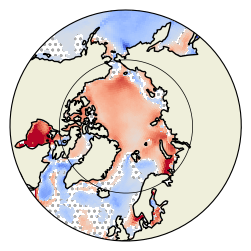

In [53]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

fig = plt.figure(figsize=(3,3)) 
# fig = plt.figure(figsize=(6,6)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());

# make the background stippled throughout the region
plt.rcParams['hatch.color'] = 'darkgray'
ax.contourf(lon, lat, areacello,
            transform=ccrs.PlateCarree(),
            colors='none',
            # levels = [.9,1.1],
            zorder = 0,
            hatches=['...'])

# add the Arctic Circle
gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=.5, color='black')
gl.ylocator = mticker.FixedLocator([66.5])
gl.xlocator = mticker.FixedLocator([])

pc = ax.pcolormesh(lon, lat, valslp, 
                   transform=ccrs.PlateCarree(), vmin = -(60/130), vmax = (60/130), cmap='coolwarm');
ax.coastlines();  ax.add_feature(cfeature.LAND, zorder = 1); #plt.colorbar(pc, orientation='horizontal', extend='both');
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/FigS5c.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()

7. Plot colorbar for the figure.

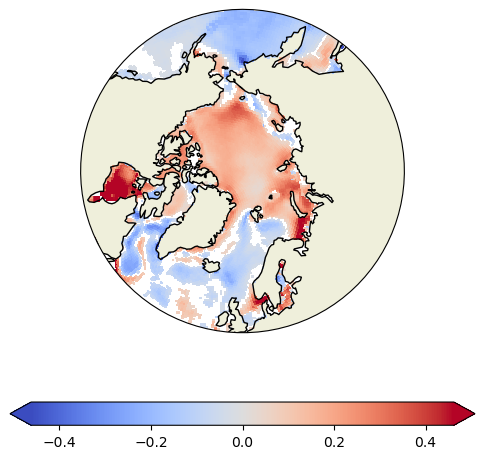

In [30]:
# make circular boundary for polar stereographic circular plots
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

#fig = plt.figure(figsize=(3,3)) 
fig = plt.figure(figsize=(6,6)) 
ax = plt.axes(projection=ccrs.NorthPolarStereo()); 
ax.set_boundary(circle, transform=ax.transAxes)
ax.set_extent([-180, 180, 50, 90], crs = ccrs.PlateCarree());
pc = ax.pcolormesh(lon, lat, valslp, 
                   transform=ccrs.PlateCarree(), vmin = -(60/130), vmax = (60/130), cmap='coolwarm');
ax.coastlines();  ax.add_feature(cfeature.LAND); 
plt.colorbar(pc, orientation='horizontal', extend='both');
figdir = '/glade/u/home/cpayne/Projects/BloomLength/Figures/FigS5cbar.png';
plt.savefig(figdir,facecolor='none', dpi = 600);
# plt.close()